# Using TensorFlow (`delta`) to solve `lagaris01`

## Introduction

The purpose of this notebook is to provide a a reference solution of the `lagaris01` ODE problem using TensorFlow and the `delta` training algorithm.

## The `lagaris01` ODE problem

This ODE was used as the first example problem in (Lagaris et al., 1998). It has been used in several other papers in the neural network/differential equation literature. The differential equation is provided in the form (equation (27) in Lagaris (1998)):

\begin{equation}
    \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi =
    x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

or:

\begin{equation}
    G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The initial condition is:

\begin{equation}
    \psi(0)=1
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

The first derivative is:

\begin{equation}
    \frac {d\psi_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

The analytical solution and derivative in the domain $[0,1]$ are plotted below.

In [1]:
# Import standard Python modules.
import datetime
import importlib
from math import exp
import matplotlib.pyplot as plt
import numpy as np
import platform
import sys
import tensorflow as tf

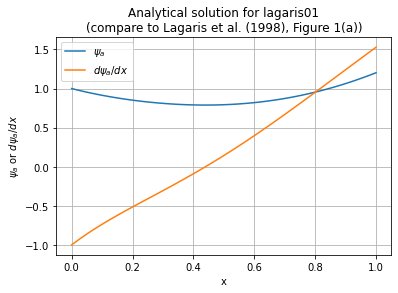

In [2]:
# Import the problem definition.
eq_name = "lagaris01"
eq_module = 'nnde.differentialequation.examples.lagaris_01'
eq = importlib.import_module(eq_module)

# Compute the analytical solution and derivative.
# Note that Y is used in place of \psi in the code.
na = 101
xa = np.linspace(0, 1, na)
Ya = np.zeros(na)
dYa_dx = np.zeros(na)
for i in range(na):
    Ya[i] = eq.Ya(xa[i])
    dYa_dx[i] = eq.dYa_dx(xa[i])

# Plot the analytical solution and derivative.
plt.plot(xa, Ya, label="$\psi_a$")
plt.plot(xa, dYa_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s\n(compare to Lagaris et al. (1998), Figure 1(a))" %
         (eq_name));

## Solving `lagaris01` using TensorFlow

In [3]:
# Hyperparameters for the problem and network.

# Number of training points and range.
nt = 11
xt_range = (0, 1)

# Number of hidden nodes.
H = 10

# Training algorithm.
training_algorithm = 'delta'

# Number of training epochs.
n_epochs = 4000

# Learning rate.
learning_rate = 0.01

# Starting ranges for network parameters.
w0_range = (-1, 1)
u0_range = (-1, 1)
v0_range = (-1, 1)

# Random number generator seed.
random_seed = 0

In [4]:
# Print the system information.
print(datetime.datetime.now())
print("Host name: %s" % platform.node())
print("OS: %s" % platform.platform())
print("uname:", platform.uname())
print("Python version: %s" % sys.version)
print("Python build:", platform.python_build())
print("Python compiler: %s" % platform.python_compiler())
print("Python implementation: %s" % platform.python_implementation())

# Create the training data.
(xmin, xmax) = xt_range
xt = np.linspace(xmin, xmax, nt)

# Convert the training data to a TensorFlow Variable.
xtv = tf.Variable(xt.reshape((nt, 1)), dtype=tf.float32)

# Create the network.
tf.random.set_seed(0)
hidden_layer = tf.keras.layers.Dense(
    units=H, use_bias=True,
    activation=tf.keras.activations.sigmoid,
    kernel_initializer=tf.keras.initializers.RandomUniform(*w0_range),
    bias_initializer=tf.keras.initializers.RandomUniform(*u0_range)
)
output_layer = tf.keras.layers.Dense(
    units=1,
    activation=tf.keras.activations.linear,
    kernel_initializer=tf.keras.initializers.RandomUniform(*v0_range),
    use_bias=False
)
model = tf.keras.Sequential([hidden_layer, output_layer])

# Train the network.
x = xtv
losses = []
phist = []
np.random.seed(random_seed)
print("\nStarting training.")
print(datetime.datetime.now())
for i in range(n_epochs):

    # Compute the forward pass for each training point.
    with tf.GradientTape(persistent=True) as tape:
        N = model(x)
        N = tf.reshape(N, (nt, 1))
        y = 1 + x*N
        dN_dx = tape.gradient(N, x)
        G = x*dN_dx + N + (x + (1 + 3*x**2)/(1 + x + x**3))*y - x**3 - 2*x - x**2*(1 + 3*x**2)/(1 + x + x**3)
        L = tf.reduce_sum(G**2)
        losses.append(L.numpy())

    # Save the parameters used in this pass.
    phist.append(
        np.hstack(
            (model.trainable_variables[0][0].numpy(),
             model.trainable_variables[1].numpy(),
             model.trainable_variables[2][:, 0].numpy())
        )
    )

    # Compute the gradients.
    grad = tape.gradient(L, model.trainable_variables)

    # Update the parameters for this pass.
    for (v, d) in zip(model.trainable_variables, grad):
        v.assign_sub(learning_rate*d)

print(datetime.datetime.now())

2021-09-01 12:47:03.449468
Host name: C02DT5CZMD6T-ML
OS: macOS-10.16-x86_64-i386-64bit
uname: uname_result(system='Darwin', node='C02DT5CZMD6T-ML', release='20.6.0', version='Darwin Kernel Version 20.6.0: Wed Jun 23 00:26:31 PDT 2021; root:xnu-7195.141.2~5/RELEASE_X86_64', machine='x86_64', processor='i386')
Python version: 3.8.10 (default, May 19 2021, 11:01:55) 
[Clang 10.0.0 ]
Python build: ('default', 'May 19 2021 11:01:55')
Python compiler: Clang 10.0.0 
Python implementation: CPython

Staring training.
2021-09-01 12:47:03.481547


2021-09-01 12:47:03.469889: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-09-01 12:47:23.639962


In [10]:
model.trainable_variables[2][:, 0].numpy()

array([-0.474737  ,  0.22459376, -1.0140628 , -0.56839716, -0.5370293 ,
       -0.29226378,  2.0879436 , -0.25698686, -0.35272816, -0.00541782],
      dtype=float32)

In [11]:
# Compute the trained solution and derivative at the training points.
with tf.GradientTape() as tape:
    N = model(xtv)
dN_dx = tape.gradient(N, xtv)
N = tf.reshape(N, (nt, 1))
dN_dx = tf.reshape(dN_dx, (nt, 1))
Ymt = 1 + xtv*N
dYmt_dx = xtv*dN_dx + N

# Compute the analytical solution and derivative at the training points.
Yat = [eq.Ya(x) for x in xt]
dYat_dx = [eq.dYa_dx(x) for x in xt]

# Compute the error in the trained solution and derivative.
err = Ymt.numpy().reshape((nt)) - Yat
derr = dYmt_dx.numpy().reshape((nt)) - dYat_dx

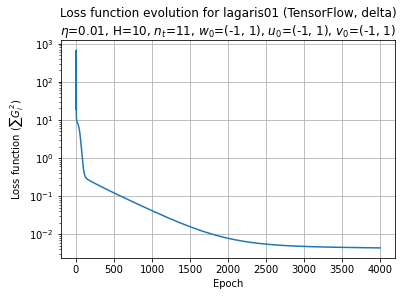

In [12]:
# Plot the loss function history.
plt.semilogy(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss function ($\sum G_i^2$)")
plt.grid()
plt.title("Loss function evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'TensorFlow', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.show()

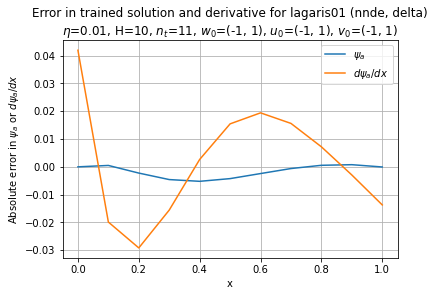

In [13]:
# Plot the errors in the trained solution and derivative.
plt.plot(xt, err, label="$\psi_a$")
plt.plot(xt, derr, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("Absolute error in $\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Error in trained solution and derivative for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'nnde', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.show()

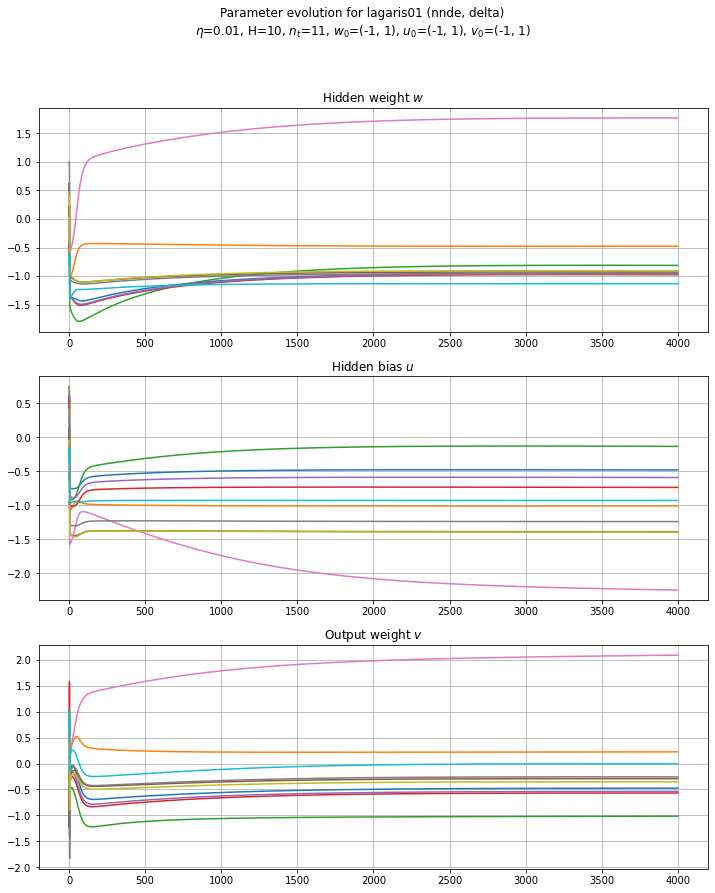

In [14]:
# Plot the parameter histories.
phist = np.array(phist)
plt.figure(figsize=(12, 14))

# w
plt.subplot(311)
plt.plot(phist[:, 0:H])
plt.title("Hidden weight $w$")
plt.grid()

# u
plt.subplot(312)
plt.plot(phist[:, H:2*H])
plt.title("Hidden bias $u$")
plt.grid()

# v
plt.subplot(313)
plt.plot(phist[:, 2*H:3*H])
plt.title("Output weight $v$")
plt.grid()

plt.suptitle("Parameter evolution for %s (%s, %s)\n$\eta$=%s, H=%s, $n_t$=%s, $w_0$=%s, $u_0$=%s, $v_0$=%s" %
          (eq_name, 'nnde', training_algorithm, learning_rate, H, nt, w0_range, u0_range, v0_range))
plt.subplots_adjust(hspace=0.2)
plt.show()